In [229]:
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [230]:
plt.style.use('fivethirtyeight')

In [231]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Preprocessed_Data')
NO2_df = pd.read_csv('NO2.csv', index_col = 0)
SSM_df = pd.read_csv('SSM.csv', index_col = 0)
Soil_Temp_df = pd.read_csv('Soil_Temperature.csv', index_col = 0)
Ozon_df =  pd.read_csv('Ozon.csv', index_col = 0)
PM25_df = pd.read_csv('PM2.5.csv', index_col = 0)


In [232]:
SSM_df_selected = pd.melt(SSM_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=SSM_df.columns[13:-31])
SSM_df_selected = SSM_df_selected.rename(columns={"variable": 'Date', 'value': 'SSM'})


In [233]:
NO2_df_selected = pd.melt(NO2_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=NO2_df.columns[16:-24])
NO2_df_selected = NO2_df_selected.rename(columns={"variable": 'Date', 'value': 'NO2 (Dobson Units)'})

In [234]:
Soil_Temp_df_selected = pd.melt(Soil_Temp_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=Soil_Temp_df.columns[16:-24])
Soil_Temp_df_selected = Soil_Temp_df_selected.rename(columns={"variable": 'Date', 'value': 'Soil Temperature (Celcius)'})


In [235]:
Ozon_df_selected = pd.melt(Ozon_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=Ozon_df.columns[16:-24])
Ozon_df_selected = Ozon_df_selected.rename(columns={"variable": 'Date', 'value': 'Ozon (Billion Molecules/mm2)'})

In [236]:
PM25_df_selected = pd.melt(PM25_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=PM25_df.columns[16:-12])
PM25_df_selected = PM25_df_selected.rename(columns={"variable": 'Date', 'value': 'PM2.5 (ug/m3)'})

In [237]:
len(SSM_df_selected), len(NO2_df_selected), len(Soil_Temp_df_selected), len(Ozon_df_selected), len(PM25_df_selected)

(28416, 28416, 28416, 28416, 28416)

In [238]:
total = pd.concat([NO2_df_selected, Soil_Temp_df_selected[['Soil Temperature (Celcius)']], SSM_df_selected[['SSM']], Ozon_df_selected['Ozon (Billion Molecules/mm2)'], PM25_df_selected['PM2.5 (ug/m3)']], axis=1)
total['Date'] =  pd.to_datetime(total['Date'])
total['Year'] = (total['Date']).dt.year
total['Month'] = (total['Date']).dt.month

total['Year'] = total['Year'].astype(int)
total['Month'] = total['Month'].astype(int)


print('Amount of missing values: ' + str(total.isnull().sum().sum()))

Amount of missing values: 259


In [239]:
total = total.dropna()

In [240]:
train = total[total['Date']<'2019']
test = total[total['Date']>='2019']
print(len(train), len(test))

21077 7080


In [241]:
feature_list = ['Soil Temperature (Celcius)', 'SSM', 'Month']
predictor = 'NO2 (Dobson Units)'


In [242]:
features = np.array(total[feature_list])
features_y = np.array(total[predictor])

In [243]:
x_train = np.array(train[feature_list])
y_train = np.array(train[predictor])
y_train = y_train.reshape(-1, 1)



In [244]:
scaler_x_train = preprocessing.StandardScaler().fit(x_train)
scaler_y_train = preprocessing.StandardScaler().fit(y_train)

x_train_scaled = scaler_x_train.transform(x_train)
y_train_scaled = scaler_y_train.transform(y_train)

In [245]:
x_test = np.array(test[feature_list])
y_test = np.array(test[predictor])
y_test = y_test.reshape(-1, 1)

In [246]:
scaler_x_test = preprocessing.StandardScaler().fit(x_train)
scaler_y_test = preprocessing.StandardScaler().fit(y_train)


x_test_scaled = scaler_x_test.transform(x_test)
y_test_scaled = scaler_y_test.transform(y_test)

In [247]:
def subsets (l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list


# Linear Regression

In [248]:
model = LinearRegression()

In [249]:
model = LinearRegression().fit(x_train_scaled, y_train_scaled)

In [250]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"Slopes:")
for i in range(0, len(feature_list)):
    print(feature_list[i] + ': '+ str(model.coef_[0][i]))

coefficient of determination: -5.769210656432341
intercept: [-4.12457569e-16]
Slopes:
Soil Temperature (Celcius): 0.053741547710650095
SSM: -0.5717479094549462
Month: 0.049486927737779005


In [251]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler_y_test.inverse_transform(y_pred_scaled)

In [252]:
errors_scaled = abs(y_pred_scaled - y_test_scaled)

print('Mean Absolute Error:', round(np.mean(errors_scaled), 2))
print('Average NO2 (Dobson Units): ' + str(y_test_scaled.mean()))

Mean Absolute Error: 0.56
Average NO2 (Dobson Units): -0.15020568224567205


In [253]:
mandal_name = 'Yellandu'

mandal_y_test = np.array(test[test['Mandal_Nam']==mandal_name][predictor])
mandal_x_test = np.array(test[test['Mandal_Nam']==mandal_name][feature_list])

mandal_x_test_scaled = scaler_x_test.transform(mandal_x_test)
mandal_y_pred_scaled = model.predict(mandal_x_test)
mandal_y_pred = scaler_y_test.inverse_transform(mandal_y_pred_scaled)

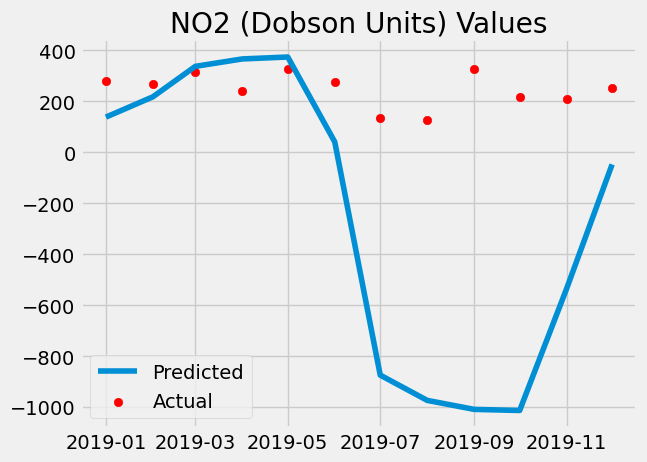

In [254]:
dates = test[test['Mandal_Nam']==mandal_name]['Date']

plt.plot(dates, mandal_y_pred, label='Predicted')
plt.scatter(dates, mandal_y_test, label = 'Actual', color = 'red')
plt.legend()
plt.title(predictor + ' Values')
plt.show()

# Random Forest
###### https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [274]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth = 2)  #max_depth can be added

y_train = y_train.reshape(len(train),)
y_test = y_test.reshape(len(test),)

rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=1000, random_state=42)

In [275]:
predictions = rf.predict(x_test)

In [276]:
errors = abs(predictions - y_test)

print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Average ' + str(predictor) + ': ' + str(total[predictor].mean()))

Mean Absolute Error: 57.66
Average NO2 (Dobson Units): 237.02857721111545


In [277]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 69.75 %.


2
4
6
8


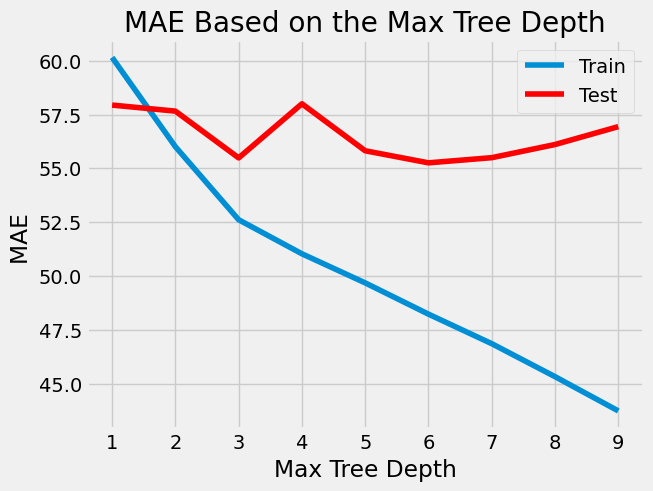

In [278]:
MAE_test = []
MAE_train = []

depth = 10

for maxdepth in range(1, depth):
    if maxdepth%2==0:
        print(maxdepth)
    rf_trial = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth = maxdepth) 
    rf_trial.fit(x_train, y_train)
    predictions_train = rf_trial.predict(x_train)
    predictions_test = rf_trial.predict(x_test)
    MAE_train.append(round(np.mean(abs(predictions_train - y_train)), 2))
    MAE_test.append(round(np.mean(abs(predictions_test - y_test)), 2))



plt.plot([i for i in range(1, depth)], MAE_train, label='Train')
plt.plot([i for i in range(1, depth)], MAE_test, label='Test', color='red')
plt.title('MAE Based on the Max Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('MAE ')
plt.legend()
plt.show()


In [279]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [280]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: SSM                  Importance: 0.82
Variable: Month                Importance: 0.17
Variable: Soil Temperature (Celcius) Importance: 0.01


[None, None, None]

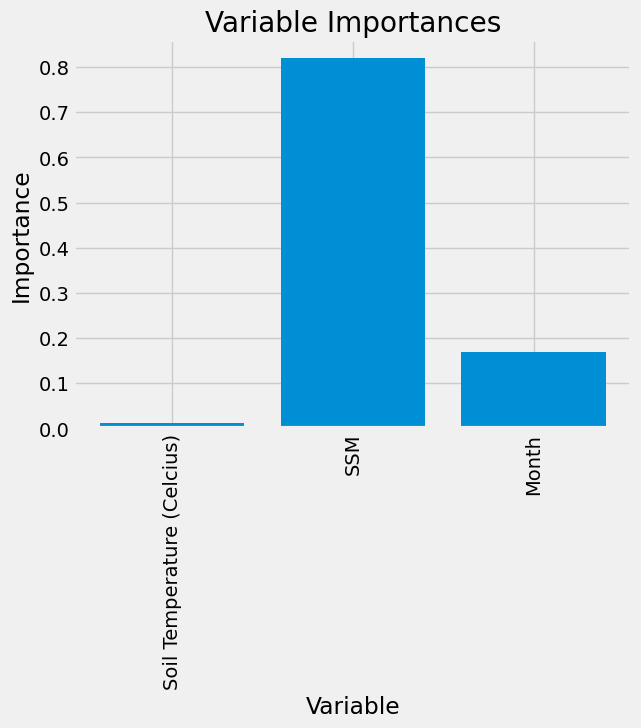

In [281]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
# Set the style
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

In [284]:
mandal_name = 'Yellandu'

test_mandal = test[test['Mandal_Nam'] == mandal_name]

predictions_mandal = rf.predict(np.array(test_mandal[feature_list]))

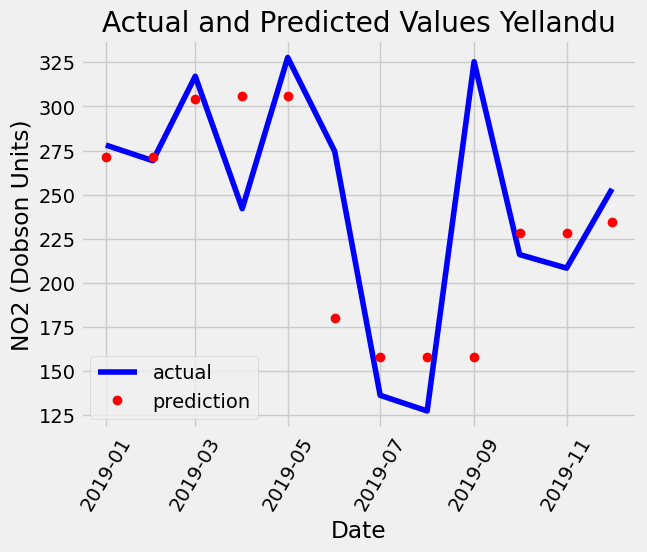

In [285]:
# Dates of training values
months = np.array(test_mandal['Month'])
days = np.empty(len(months))
days.fill(1)
years = np.array(test_mandal['Year'])

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': test_mandal[predictor]})

# Dates of predictions
months = np.array(test_mandal['Month'])
days = np.empty(len(months))
days.fill(1)
years = np.array(test_mandal['Year'])

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions_mandal})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel(predictor); plt.title('Actual and Predicted Values ' + mandal_name)
plt.show()